The purpose of this notebook is to extract additional Rrs data by using highly correlated channels adjacent to the bands of interest; in this case SeaWiFS bands.

In [28]:
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from matplotlib import rcParams
from seaborn import heatmap
from cmocean import cm
from sklearn.linear_model import LinearRegression as LR

/accounts/ekarakoy/anaconda3/envs/machine_learning/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/accounts/ekarakoy/anaconda3/envs/machine_learning/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [11]:
% matplotlib inline
pl.style.use('tableau-colorblind10')
rcParams['axes.formatter.limits'] = (-2, 3)
rcParams['axes.labelsize'] = 16
rcParams['axes.titlesize'] = 18
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['legend.fontsize'] = 16

In [29]:
def pairwise_fill(row, feature_1, feature_2):
    """simple pairwise imputation"""
    if np.isnan(row[feature_1]):
        return row[feature_2]
    else:
        return row[feature_1]

In [3]:
with open('./pickleJar/NOMAD_AOP&IOPs.pkl', 'rb') as f:
    d_dict = pickle.load(f)
    d_aop = d_dict['d_aop']

In [4]:
del d_dict
d_aop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4459 entries, 0 to 4458
Data columns (total 38 columns):
id              4459 non-null object
datetime        4459 non-null datetime64[ns]
doy             4459 non-null float64
lat             4459 non-null float64
lon             4459 non-null float64
etopo2          4459 non-null float64
bathymetry      4459 non-null float64
oisst           4459 non-null float64
wtemp           1235 non-null float64
woa_sst_mean    2516 non-null float64
woa_sst_se      2516 non-null float64
sal             672 non-null float64
woa_sal_mean    2511 non-null float64
woa_sal_se      2511 non-null float64
rrs405          12 non-null float64
rrs411          4293 non-null float64
rrs443          4456 non-null float64
rrs455          393 non-null float64
rrs465          375 non-null float64
rrs489          4422 non-null float64
rrs510          3435 non-null float64
rrs520          1559 non-null float64
rrs530          1589 non-null float64
rrs550          91

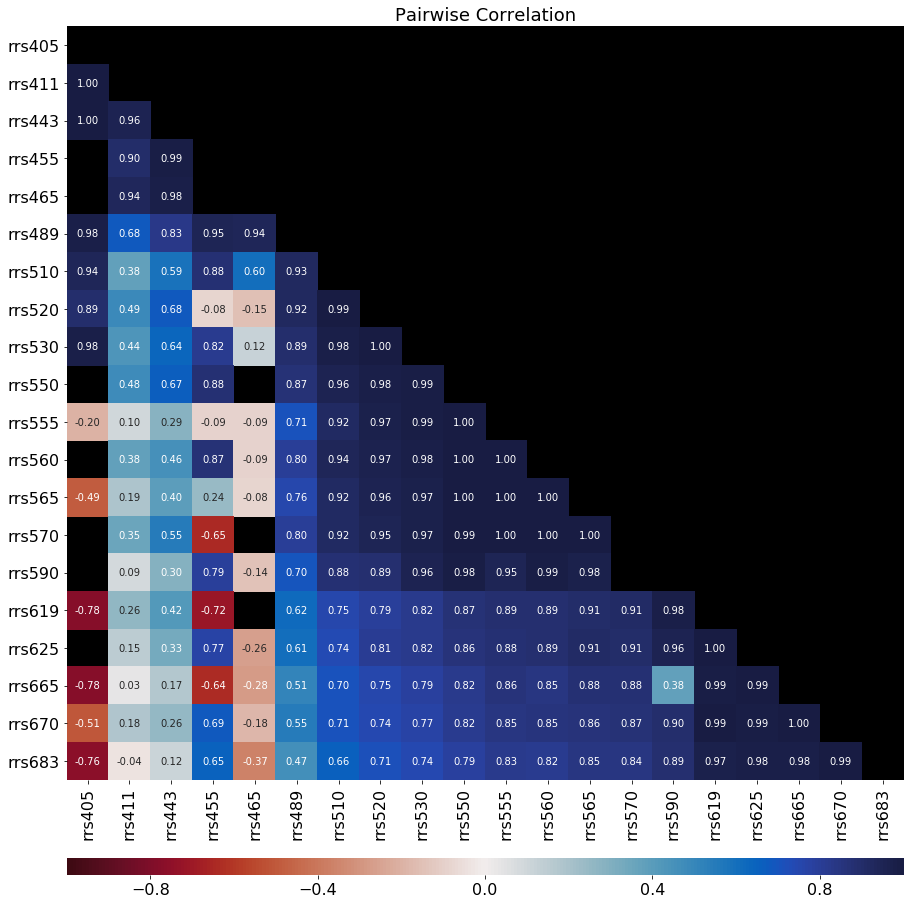

In [20]:
f, ax = pl.subplots(figsize=(15, 18))
ax.set_facecolor('k')
cols=[col for col in d_aop.columns if 'rrs' in col]
heatmap(d_aop[cols].corr(), cmap=cm.balance_r, annot=True, vmin=-1, vmax=1,
           mask=np.triu(np.ones([len(cols)]*2)), ax=ax, fmt='.2f',
          cbar_kws={'aspect': 50, 'orientation': 'horizontal', 'pad': 0.08});
ax.set_title('Pairwise Correlation')
f.savefig('./figJar/impute_1_pw_corr.png', dpi=300, format='png')

The heatmap above shows pairwise correlation between bands; the data shown is each cells indicates the Pearson correlation between crossing row/column pairs. This suggests that there is potential for missing data imputation for SeaWiFS blue (443, 489, 510), green (555), and red (670) bands. I'll explore this next. I'll start with blue bands.

#### <u>Blues</u>

In [25]:
blues = ['rrs405', 'rrs411', 'rrs443' ,'rrs455', 'rrs465', 'rrs489', 'rrs510', 'rrs520']
d_aop[blues].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4459 entries, 0 to 4458
Data columns (total 8 columns):
rrs405    12 non-null float64
rrs411    4293 non-null float64
rrs443    4456 non-null float64
rrs455    393 non-null float64
rrs465    375 non-null float64
rrs489    4422 non-null float64
rrs510    3435 non-null float64
rrs520    1559 non-null float64
dtypes: float64(8)
memory usage: 278.8 KB


There are too few Rrs405 observations available to attempt to establish a robust relationship with respect to other bands. 405 will no longer be considered.

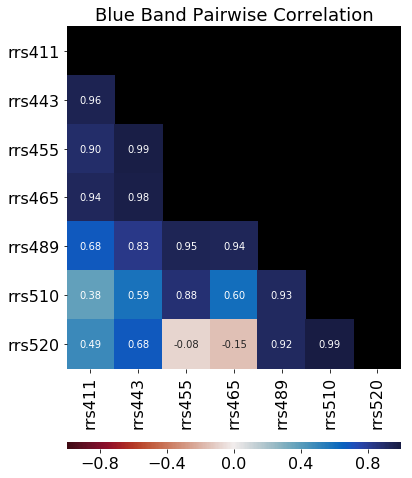

In [26]:
blues = ['rrs411', 'rrs443' ,'rrs455', 'rrs465', 'rrs489', 'rrs510', 'rrs520']
f, ax = pl.subplots(figsize=(6,9))
ax.set_facecolor('k')
ax.set_title('Blue Band Pairwise Correlation')
heatmap(d_aop[blues].corr(), cmap=cm.balance_r, annot=True, vmin=-1, vmax=1,
           mask=np.triu(np.ones([len(blues)]*2)), ax=ax, fmt='.2f',
          cbar_kws={'aspect': 50, 'orientation': 'horizontal'});
f.savefig('./figJar/impute2_pwcorr_blues.png', dpi=300, format='png')

The above suggests 455 and 465 should be examined further as as source of imputation for 443, similarly 520 is a candidate for imputing 510 values.

In [21]:
d_blues = d_aop[blues]

In [22]:
d_blues.loc[(d_blues.rrs443.isnull()) & (~d_blues.rrs455.isnull())].shape

(0, 8)

In [23]:
d_blues.loc[(d_blues.rrs443.isnull()) & (~d_blues.rrs455.isnull())].shape

(0, 8)

Unfortunately there are no observations where 443 is not available and any of 455 and 465 are. Looking at 510 & 520:

In [27]:
d_blues.loc[(d_blues.rrs510.isnull()) & (~d_blues.rrs520.isnull())].shape

(772, 8)

Here there are a fair number of 520 observations where 510 are missing. I'll examine the relationship between 510 and 520 in more detail by comparing an imputation by simple replacement and by linear regression:

In [38]:
d_blues_510_520 = d_blues[['rrs510', 'rrs520']]

In [50]:
xy_510_520_train = d_blues_510_520.dropna().as_matrix()
x_520_to_fit = d_blues_510_520.loc[(d_blues_510_520.rrs510.isnull()) &
                                  (~d_blues_510_520.rrs520.isnull()),
                                   'rrs520'].values.reshape(-1, 1)

In [47]:
y_510_train = xy_510_520_train[:, 0].reshape(-1, 1)
x_520_train = xy_510_520_train[:, 1].reshape(-1, 1)

In [37]:
lr510 = LR()

In [48]:
lr510.fit(x_520_train, y_510_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [51]:
y_510_predict = lr510.predict(x_520_to_fit)

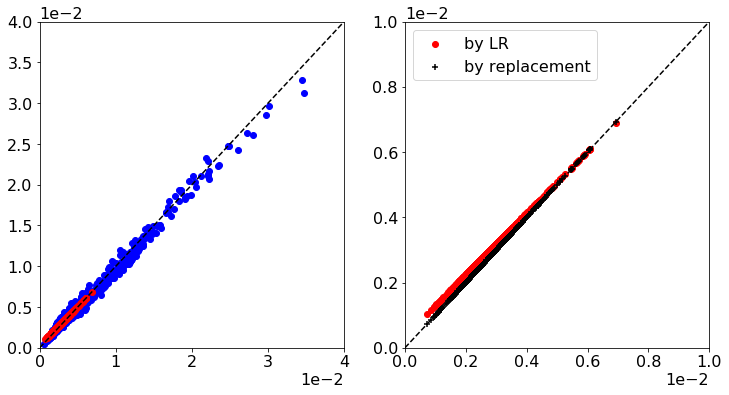

In [56]:
max_impute_rrs520 = d_blues.loc[(d_blues.rrs510.isnull()) & (~d_blues.rrs520.isnull()),
                                'rrs520']
lims = [0, 4e-2]
lims2 = [0, 1e-2]
f, axs = pl.subplots(ncols=2, figsize=(12,6))
axs[0].plot(lims, lims, 'k--')
axs[0].set_xlim(lims)
axs[0].set_ylim(lims)
axs[0].scatter(x_520_train, y_510_train, marker='o', color='b')
axs[0].scatter(x_520_to_fit, y_510_predict, marker='o', color='r');
axs[1].plot(lims2, lims2, 'k--')
axs[1].set_xlim(lims2)
axs[1].set_ylim(lims2)
axs[1].scatter(x_520_to_fit, y_510_predict, marker='o', color='r', label='by LR');
axs[1].scatter(x_520_to_fit, x_520_to_fit, marker='+', color='k', label='by replacement');
axs[1].legend()
#ax.axvline(0.007)

So there appear to be a slight deviation with the regression line; not enough to justify not do imputation by direct replacement. I 'll therefore use the pairwise_fill function, defined above to impute by replacement.